<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/system_identification_from_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Identification from Data


In [ ]:
from jax import random
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp 

In [ ]:
plt.rcParams['figure.dpi'] = 200

The motion of an unforced harmonic oscillator can be described by the following coupled system:
   \begin{align*}
   \dot{x}_1(t) &= x_2(t)\\
   \dot{x}_2(t) &= -kx_1(t) - cx_2(t)  \enspace .
   \end{align*}
In this problem, we assume that $t_0 = 0$, $t_f = 10$ and that the initial state is $\textbf{x}(0) = [10, 0]$. We are interested in identifying the vector of true parameters $\theta = [c, k]$ from data. 

In [ ]:
def harmonic_oscillator_ivp(c=1, k=1):
  def dynamics(t, x): 
    return jnp.array([x[1], -k*x[0] - c*x[1]])

  x0 = jnp.array([10., 0.])
  #s0 = IMPLEMENT: initial state of the sensitivity equation
  s0 = jnp.array([[0., 0.], [0., 0.]])
  z0 = jnp.concatenate((x0, jnp.ravel(s0)))

  # dx_f = IMPLEMENT: D_x f(x(t), t, \theta). You can just compute it by hand, no need for JAX
  dx_f = jnp.array([[0., 1.], [-k, -c]])

  def augmented_dynamics(t, z):
    x, s = z[:2], z[2:]
    s = jnp.reshape(s, (2,2))

    # dtheta_f = IMPLEMENT: D_theta f(x(t), t, \theta). You can just compute it by hand, no need for JAX
    dtheta_f = jnp.array([[0, 0], [-x[1], -x[0]]])
    xprime = dynamics(t, x)
    # sprime = IMPLEMENT: The sensitivity equation
    sprime = dx_f @ s + dtheta_f
    zprime = jnp.concatenate((xprime, jnp.ravel(sprime)))
    return zprime

  return augmented_dynamics, z0

In [ ]:
def solve_system(params, t_span, t_eval):
  augmented_dynamics, z0 = harmonic_oscillator_ivp(*params)
  solution = solve_ivp(augmented_dynamics, t_span, z0, t_eval=t_eval)
  trajectory = solution.y[:2,:].T
  sensitivities = jnp.reshape(solution.y[2:,:], (2, 2, 100))
  sensitivities = jnp.rollaxis(sensitivities, -1, 0)
  return trajectory, sensitivities

For this problem we use the square error loss: 
\begin{align*}
\frac{1}{2}\sum_{i=1}^N \| x(t_i, \theta) - x^\star(t_i)\|^2 \enspace ,
\end{align*}
where $x^\star(t_i)$ comes from the reference trajectory and $x(t_i, \theta)$ is from our model.

In [ ]:
def value_and_grad(params, t_span, t_eval, reference_trajectory):
  trajectory, sensitivities = solve_system(params, t_span, t_eval)
  
  #value = IMPLEMENT: l(\theta^{(k)}) = (1/2) \sum_{i=1}^N \| x(t_i, \theta^{(k)}) - x^*(t_i)) \|^2
  # grad_loss = IMPLEMENT: D_\theta l(\theta^{(k)})
  value = 0.5 * jnp.einsum('i->', jnp.linalg.norm(trajectory - reference_trajectory, axis = 1)**2)
  grad_loss = jnp.einsum('ij,ijk->k', trajectory - reference_trajectory, sensitivities)
  return value, grad_loss

In [ ]:
nsamples = 100
t_span = jnp.array([0., 10.])
true_params = jnp.array([1., 1.])
t_eval = jnp.linspace(*t_span, nsamples)
key = random.PRNGKey(0)
reference_trajectory, sens = solve_system(true_params, t_span, t_eval)

## Experiment 
In order to simulate an experimental setup in which we would be trying to identify the system from data, we generate a trajectory of the true underlying deterministic system at $\theta = [1, 1]$ and perturb the resulting trajectory with normal noise.

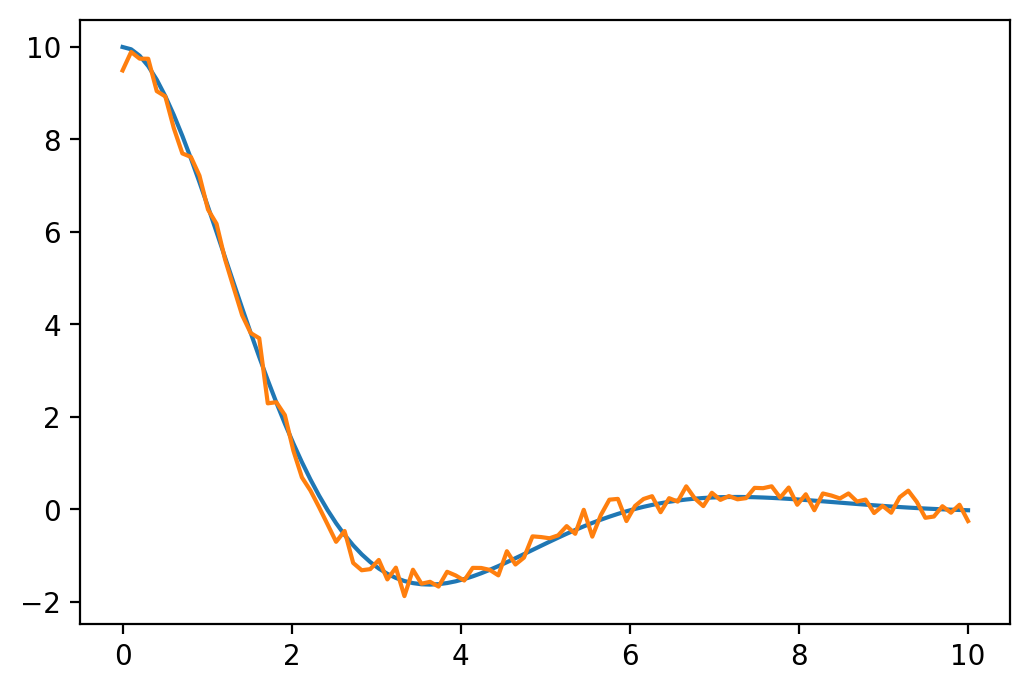

In [ ]:
nsamples = 100
t_span = jnp.array([0., 10.])
true_params = jnp.array([1., 1.])
t_eval = jnp.linspace(*t_span, nsamples)

key = random.PRNGKey(0)
reference_trajectory, _ = solve_system(true_params, t_span, t_eval)
noisy_trajectory = reference_trajectory + 0.2*random.normal(key, shape=reference_trajectory.shape)

plt.plot(t_eval, reference_trajectory[:,0])
plt.plot(t_eval, noisy_trajectory[:, 0])

As a sanity check, the value of the loss and gradient evaluated under the true trajectory (noiseless) should be zero:

In [ ]:
value_and_grad(true_params, t_span, t_eval, reference_trajectory)

(DeviceArray(0., dtype=float32), DeviceArray([0., 0.], dtype=float32))

Use the Adam optimizer, to identify the true parameters $\theta = [1, 1]$ from an initial guess of $\theta = [0.5, 0.5]$. 

In [ ]:
from jax.experimental import optimizers

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)

num_steps = 100
init_params = jnp.array([0.5, 0.5])
opt_state = opt_init(init_params)

def step(i, opt_state):
    value, grads = value_and_grad(get_params(opt_state), t_span, t_eval, reference_trajectory)
    return value, opt_update(i, grads, opt_state)

for i in range(num_steps):
    value, opt_state = step(i, opt_state)
    print(f"Step {i} value {value}")
    identified_trajectory, _ = solve_system(get_params(opt_state), t_span, t_eval)
    plt.ylim(-5, 10)
    plt.title(f"Iteration {i}")
    plt.plot(t_eval, reference_trajectory[:,0])
    plt.plot(t_eval, identified_trajectory[:, 0])
    plt.savefig(f"{i}.png")
    plt.clf()

Step 0 value 169.8596954345703
Step 1 value 159.42697143554688
Step 2 value 149.54183959960938
Step 3 value 140.18795776367188
Step 4 value 131.3480987548828
Step 5 value 123.00439453125
Step 6 value 115.13817596435547
Step 7 value 107.73049926757812
Step 8 value 100.76197052001953
Step 9 value 94.21302795410156
Step 10 value 88.06413269042969
Step 11 value 82.29589080810547
Step 12 value 76.88916015625
Step 13 value 71.82508850097656
Step 14 value 67.08538818359375
Step 15 value 62.65222930908203
Step 16 value 58.50835418701172
Step 17 value 54.637168884277344
Step 18 value 51.022705078125
Step 19 value 47.64975357055664
Step 20 value 44.503761291503906
Step 21 value 41.57065200805664
Step 22 value 38.83720016479492
Step 23 value 36.29079818725586
Step 24 value 33.919437408447266
Step 25 value 31.711780548095703
Step 26 value 29.65706443786621
Step 27 value 27.745126724243164
Step 28 value 25.966358184814453
Step 29 value 24.311687469482422
Step 30 value 22.772560119628906
Step 31 val

<Figure size 1200x800 with 0 Axes>

In [ ]:
! ffmpeg -i %d.png progression.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progression.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)